In [11]:
import os
import sys
source_path = os.path.join("src/")
sys.path.insert(0,source_path)
import east_model as em
import value_mps as vm
import policy_mps
import actor_critic_observations as ac
import observations as obs
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax.lax import cond, fori_loop
import numpy as np
# from jax.config import config
# config.update("jax_debug_nans", True)

In [12]:
key = random.PRNGKey(10)
sites = 4
bias = 0.1
environment_args = dict(
	L = sites,
	s = bias,
)
key, subkey = random.split(key)
state = random.randint(subkey, (sites,), 0, 2)
value_bond_dim = 4
key, subkey = random.split(key)
value_params = random.normal(subkey, (2, value_bond_dim, value_bond_dim))*0.45
policy_bond_dim = 16
key, subkey = random.split(key)
policy_params = random.normal(subkey, (2, 2, policy_bond_dim, policy_bond_dim))*0.2
key, subkey = random.split(key)


In [13]:
obs_func = obs.observation_vec_to_func(
	[obs.average_reward_observation,
	 em.activity_observation, 
	 em.kl_divergence_observation],
	[0, 0.0003, 0.0003]
)
initial_av_rew = 0.0
initial_obs = jnp.array([initial_av_rew, 0.0, 0.0])
alg_step = ac.init_actor_critic(
	em.periodic_reward_func,
	em.step,
	environment_args,
	vm.value_scan,
	0.1,
	policy_mps.policy,
	0.1,
	0.001,
	obs_func
)

In [14]:
initial_obs.shape

(3,)

In [15]:
train = jit(ac.train, static_argnums=(4,5,7))

In [16]:
number_of_saves = 100
save_frequence = 100
total_steps = number_of_saves*save_frequence

In [17]:
_, _, _, _, _, observations = train(
    state, key, value_params, policy_params, alg_step, 
    number_of_saves, initial_obs, save_frequence, initial_av_rew)

In [18]:
%timeit _, _, _, _, _, observations = train(state, key, value_params, policy_params, alg_step, number_of_saves, initial_obs, save_frequence, initial_av_rew)

3.08 s ± 145 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [24]:
import numpy as np
exact_data = np.load('../data_processing/Data/scgf_activity_periodic_s-0.1to0.2_st0.01_N3to10.npy')
lattice_sizes_exact = list(range(3,11))
biases_exact = np.round_(np.load('../data_processing/Data/east_diag_biases.npy'),6)
exact_theta = exact_data[lattice_sizes_exact.index(4),0,biases_exact==bias]
print(exact_theta)

[-0.0498699]


In [25]:
observations.shape

(1000, 1027)

In [26]:
filename = "./Data/periodic_dmrg_data.hdf5"
import h5py

with h5py.File(filename, "r") as f:
    # List all groups
    # print("Keys: %s" % f.keys())
    group_keys = list(f.keys())


    # Get the data
    biases_dmrg_pbc = np.array(list(f[group_keys[0]]))
    data_dmrg_pbc = np.array(list(f[group_keys[1]]))
    lattice_sizes_dmrg_pbc = np.array(list(f[group_keys[2]]))

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = './Data/periodic_dmrg_data.hdf5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

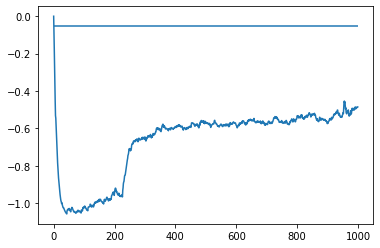

In [8]:
from matplotlib import pyplot as plt
plt.plot(observations[:,0])
plt.hlines(exact_theta[0], 0, len(observations[:]))

In [9]:
%timeit _, _, _, _, _, av_rew = train(state, key, value_params, policy_params, alg_step, 10, initial_obs, 1)

3.08 ms ± 89.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
%timeit _, _, _, _, _, av_rew = train(state, key, value_params, policy_params, alg_step, 100, initial_obs, 1)

38.2 ms ± 622 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%timeit _, _, _, _, _, av_rew = train(state, key, value_params, policy_params, alg_step, 1000, initial_obs, 1)

In [ ]:
%timeit _, _, _, _, _, av_rew = train(state, key, value_params, policy_params, alg_step, 10000, initial_obs, 1)

In [ ]:
%timeit _, _, _, _, _, av_rew = train(state, key, value_params, policy_params, alg_step, 100000, initial_obs, 1)

In [ ]:
%timeit _, _, _, _, _, av_rew = train(state, key, value_params, policy_params, alg_step, 1000, initial_obs, 100)

In [ ]:
%timeit _, _, _, _, _, av_rew = train(state, key, value_params, policy_params, alg_step, 1000000, initial_obs, 1)

In [ ]:
%timeit _, _, _, _, _, av_rew = train(state, key, value_params, policy_params, alg_step, 10000, initial_obs, 100)